# LGB Data Scaling Experiment — Analysis

Plots from the `full-doubling-v3` W&B run (32 grid points: 8 data fractions x 4 model capacities).

In [1]:
import wandb
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import numpy as np

api = wandb.Api()
run = api.run('kquity-lgb-scaling/jogqgngg')
art = [a for a in run.logged_artifacts() if 'results_table' in a.name][0]
table = art.get('results_table')
df = pd.DataFrame(table.data, columns=table.columns)
df

wandb: [wandb.Api()] Loaded credentials for https://api.wandb.ai from /home/rrenaud/.netrc.


wandb:   1 of 1 files downloaded.  


,fraction,capacity,num_train_samples,val_log_loss,val_accuracy,val_inversions,holdout_log_loss,holdout_accuracy,holdout_inversions,train_time_s
0,0.01,31L/50T,90080,0.581156,0.685136,0.0380,0.580285,0.677952,0.0485,0.2
1,0.01,100L/100T,90080,0.586547,0.680971,0.0790,0.596827,0.671616,0.0945,0.9
2,0.01,200L/200T,90080,0.609872,0.673750,0.1280,0.636204,0.661676,0.1350,2.7
3,0.01,500L/300T,90080,0.686311,0.664155,0.1720,0.737637,0.656582,0.2080,9.4
4,0.02,31L/50T,188006,0.579969,0.684932,0.0325,0.578275,0.682177,0.0245,0.5
5,0.02,100L/100T,188006,0.578881,0.685227,0.0585,0.582151,0.680251,0.0575,1.2
6,0.02,200L/200T,188006,0.589862,0.680551,0.0955,0.595153,0.681245,0.1220,3.2
7,0.02,500L/300T,188006,0.624518,0.672209,0.1345,0.637772,0.670311,0.1715,9.4
8,0.04,31L/50T,373542,0.579258,0.684690,0.0245,0.574603,0.686525,0.0215,0.7
9,0.04,100L/100T,373542,0.575860,0.686290,0.0360,0.573213,0.684786,0.0275,1.7


In [2]:
CAPACITIES = ['31L/50T', '100L/100T', '200L/200T', '500L/300T']
CAP_COLORS = {'31L/50T': '#1f77b4', '100L/100T': '#ff7f0e',
              '200L/200T': '#2ca02c', '500L/300T': '#d62728'}
METRICS = [
    ('log_loss', 'Log Loss', False),
    ('accuracy', 'Accuracy', True),
    ('inversions', 'Egg Inversions', False),
]

def fmt_samples(x, _):
    if x >= 1e6:
        return f'{x/1e6:.1f}M'
    if x >= 1e3:
        return f'{x/1e3:.0f}K'
    return f'{x:.0f}'

## 1. Metrics vs Training Data Size (one line per capacity)

Each subplot shows how a metric evolves as we scale training data from 1% to 100% of partitions. Separate lines per model capacity.

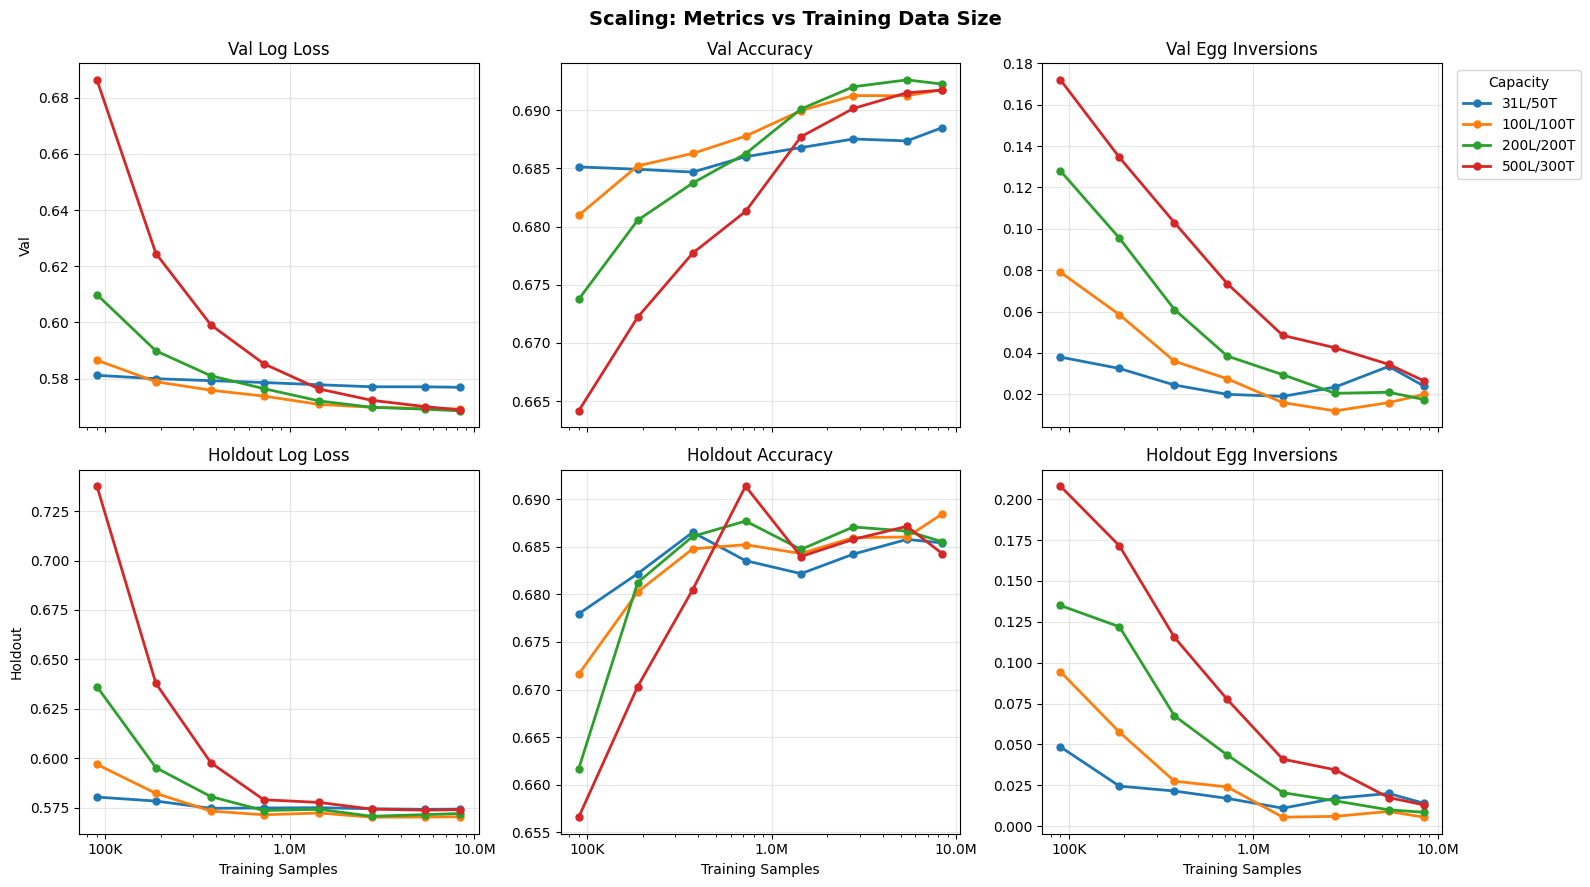

In [3]:
fig, axes = plt.subplots(2, 3, figsize=(16, 9), sharex=True)

for col, (metric, label, higher_better) in enumerate(METRICS):
    for split_idx, split in enumerate(['val', 'holdout']):
        ax = axes[split_idx, col]
        col_name = f'{split}_{metric}'
        for cap in CAPACITIES:
            sub = df[df['capacity'] == cap].sort_values('num_train_samples')
            ax.plot(sub['num_train_samples'], sub[col_name],
                    marker='o', color=CAP_COLORS[cap], label=cap, linewidth=2, markersize=5)
        ax.set_xscale('log')
        ax.xaxis.set_major_formatter(mticker.FuncFormatter(fmt_samples))
        ax.set_title(f'{split.title()} {label}')
        if split_idx == 1:
            ax.set_xlabel('Training Samples')
        ax.grid(True, alpha=0.3)
        if col == 0:
            ax.set_ylabel(split.title())

axes[0, 2].legend(title='Capacity', bbox_to_anchor=(1.02, 1), loc='upper left')
fig.suptitle('Scaling: Metrics vs Training Data Size', fontsize=14, fontweight='bold')
fig.tight_layout()
plt.savefig('plot_metrics_vs_data.png', dpi=150, bbox_inches='tight')
plt.show()

## 2. Val vs Holdout Comparison (per capacity)

Overlays validation and holdout on the same axes to directly compare generalization gap.

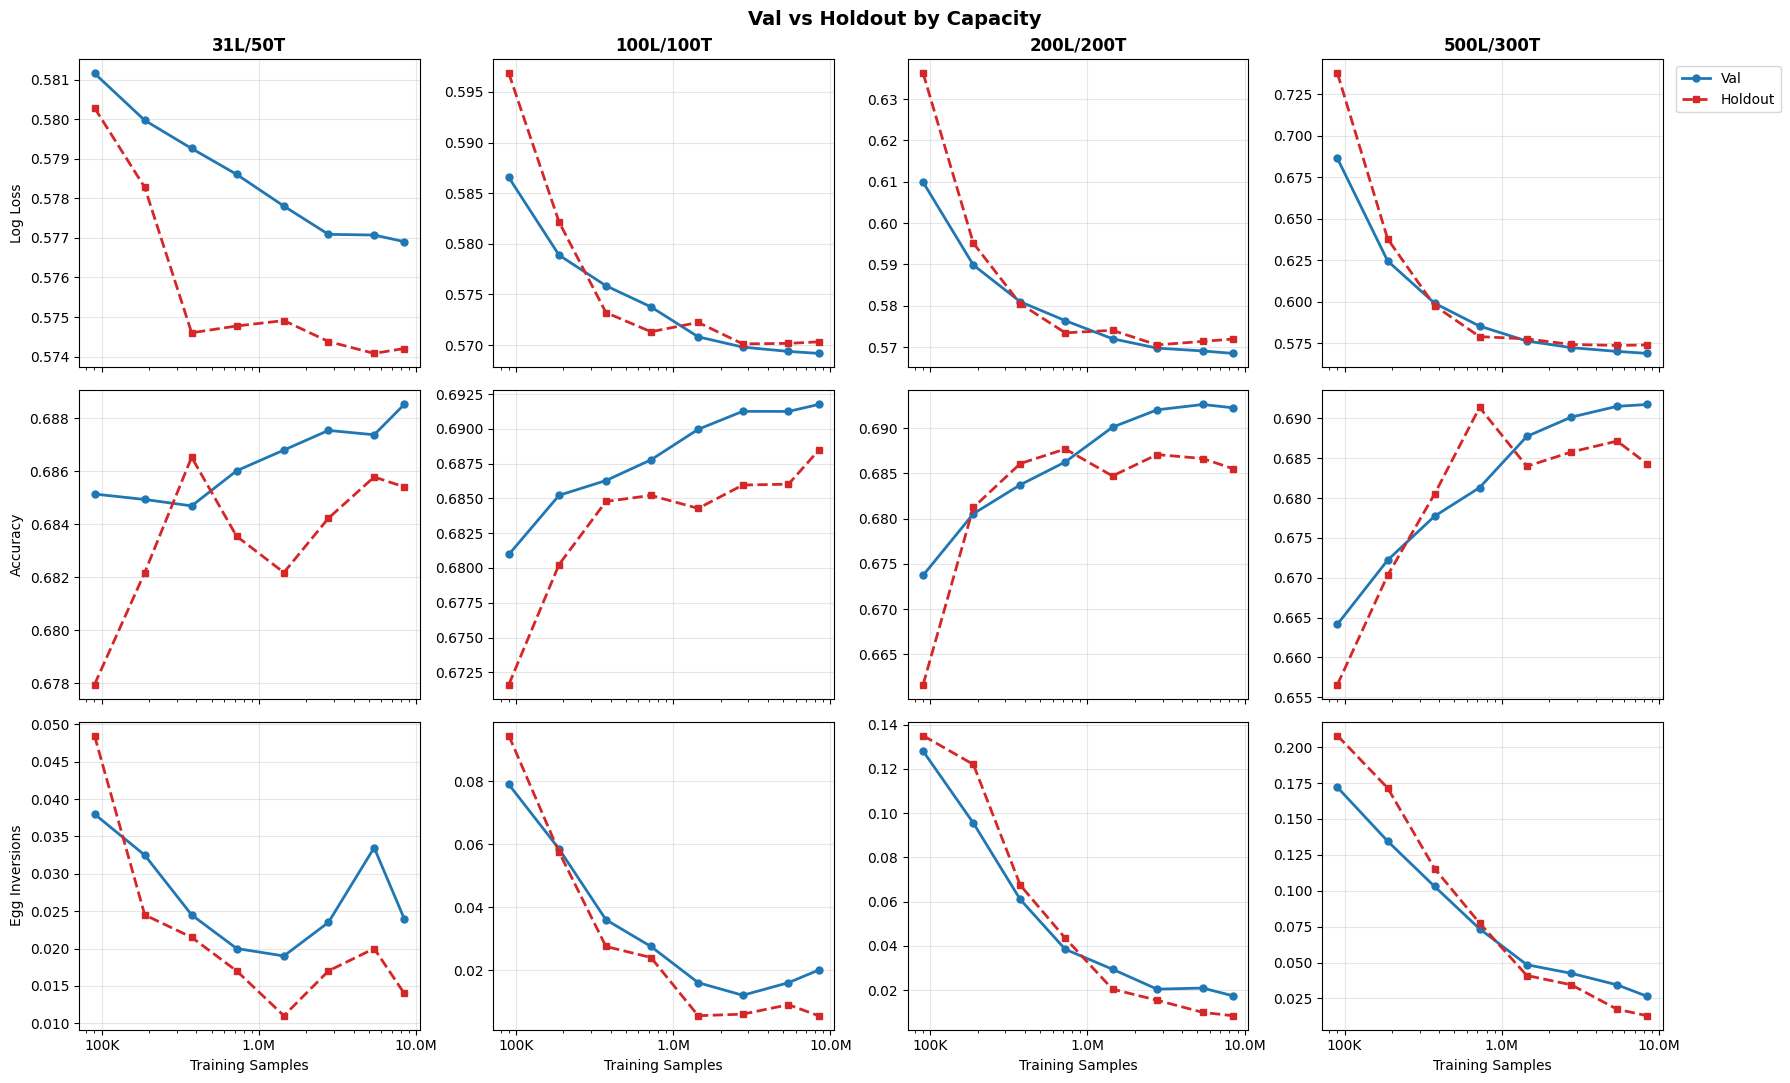

In [4]:
fig, axes = plt.subplots(3, 4, figsize=(18, 11), sharex=True)

for col, cap in enumerate(CAPACITIES):
    sub = df[df['capacity'] == cap].sort_values('num_train_samples')
    for row, (metric, label, higher_better) in enumerate(METRICS):
        ax = axes[row, col]
        ax.plot(sub['num_train_samples'], sub[f'val_{metric}'],
                marker='o', color='#1f77b4', label='Val', linewidth=2, markersize=5)
        ax.plot(sub['num_train_samples'], sub[f'holdout_{metric}'],
                marker='s', color='#d62728', label='Holdout', linewidth=2, markersize=5, linestyle='--')
        ax.set_xscale('log')
        ax.xaxis.set_major_formatter(mticker.FuncFormatter(fmt_samples))
        ax.grid(True, alpha=0.3)
        if row == 0:
            ax.set_title(cap, fontsize=12, fontweight='bold')
        if row == 2:
            ax.set_xlabel('Training Samples')
        if col == 0:
            ax.set_ylabel(label)

axes[0, 3].legend(bbox_to_anchor=(1.02, 1), loc='upper left')
fig.suptitle('Val vs Holdout by Capacity', fontsize=14, fontweight='bold')
fig.tight_layout()
plt.savefig('plot_val_vs_holdout.png', dpi=150, bbox_inches='tight')
plt.show()

## 3. Metrics vs Capacity (one line per data fraction)

For each training data size, shows how metrics change as model capacity increases.

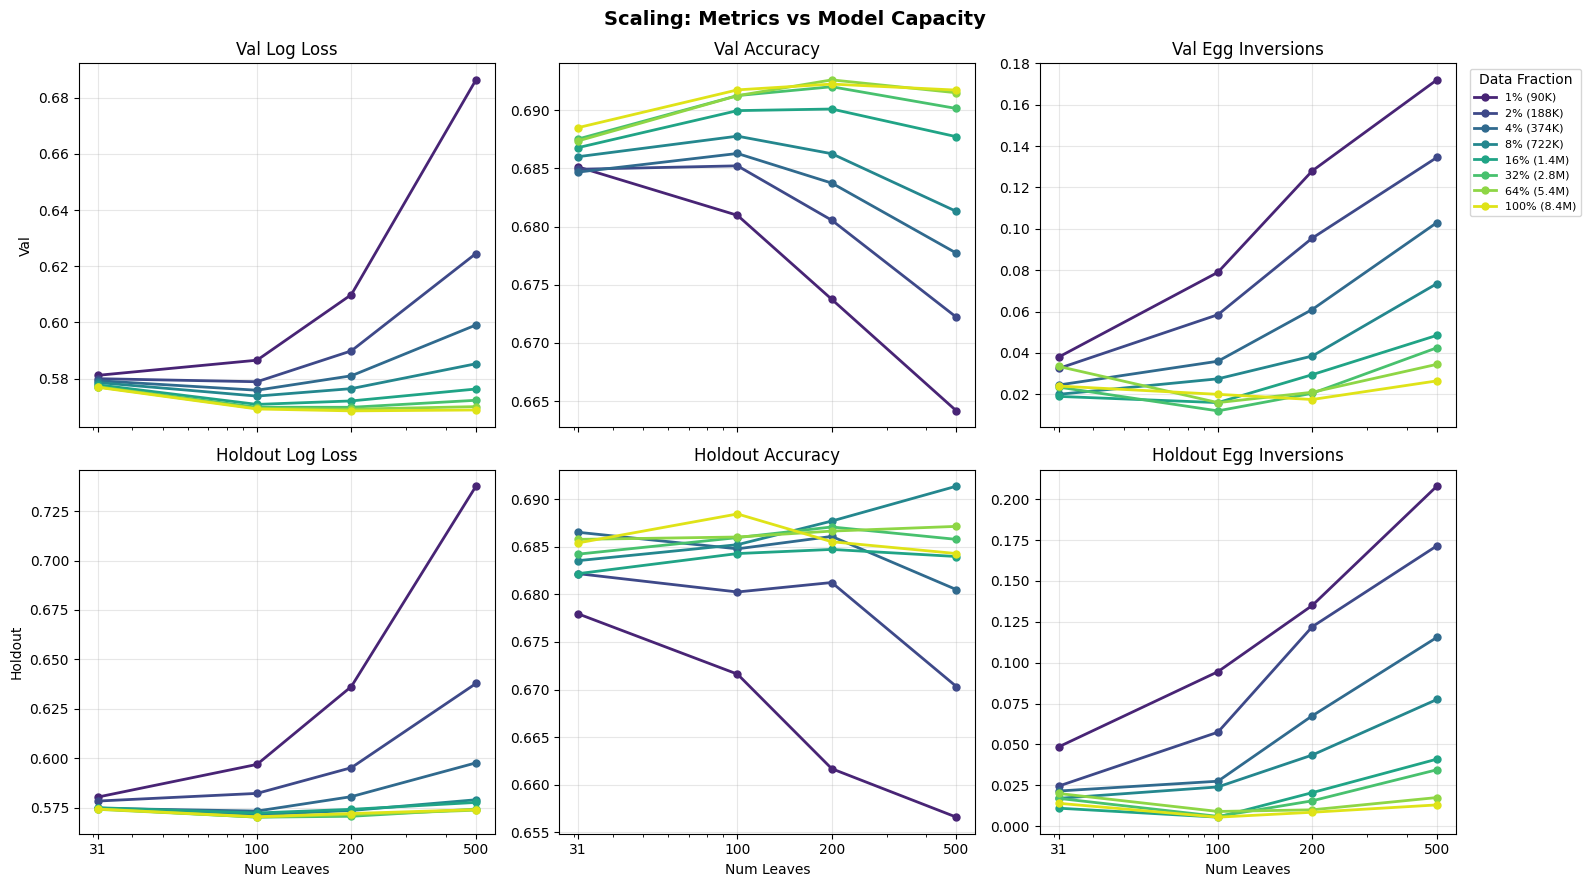

In [5]:
fractions = sorted(df['fraction'].unique())
cmap = plt.cm.viridis(np.linspace(0.1, 0.95, len(fractions)))
frac_colors = dict(zip(fractions, cmap))

# Use num_leaves as a proxy for capacity on x-axis
cap_to_leaves = {'31L/50T': 31, '100L/100T': 100, '200L/200T': 200, '500L/300T': 500}
df['num_leaves_x'] = df['capacity'].map(cap_to_leaves)

fig, axes = plt.subplots(2, 3, figsize=(16, 9), sharex=True)

for col, (metric, label, higher_better) in enumerate(METRICS):
    for split_idx, split in enumerate(['val', 'holdout']):
        ax = axes[split_idx, col]
        col_name = f'{split}_{metric}'
        for frac in fractions:
            sub = df[df['fraction'] == frac].sort_values('num_leaves_x')
            n = sub['num_train_samples'].iloc[0]
            lbl = f'{frac:.0%} ({n/1e6:.1f}M)' if n >= 1e6 else f'{frac:.0%} ({n/1e3:.0f}K)'
            ax.plot(sub['num_leaves_x'], sub[col_name],
                    marker='o', color=frac_colors[frac], label=lbl, linewidth=2, markersize=5)
        ax.set_xscale('log')
        ax.set_xticks([31, 100, 200, 500])
        ax.xaxis.set_major_formatter(mticker.ScalarFormatter())
        ax.set_title(f'{split.title()} {label}')
        if split_idx == 1:
            ax.set_xlabel('Num Leaves')
        ax.grid(True, alpha=0.3)
        if col == 0:
            ax.set_ylabel(split.title())

axes[0, 2].legend(title='Data Fraction', bbox_to_anchor=(1.02, 1), loc='upper left', fontsize=8)
fig.suptitle('Scaling: Metrics vs Model Capacity', fontsize=14, fontweight='bold')
fig.tight_layout()
plt.savefig('plot_metrics_vs_capacity.png', dpi=150, bbox_inches='tight')
plt.show()

## 4. Val-Holdout Gap Analysis

How much worse is holdout than val? Positive gap = holdout is worse (higher loss, lower accuracy, higher inversions).

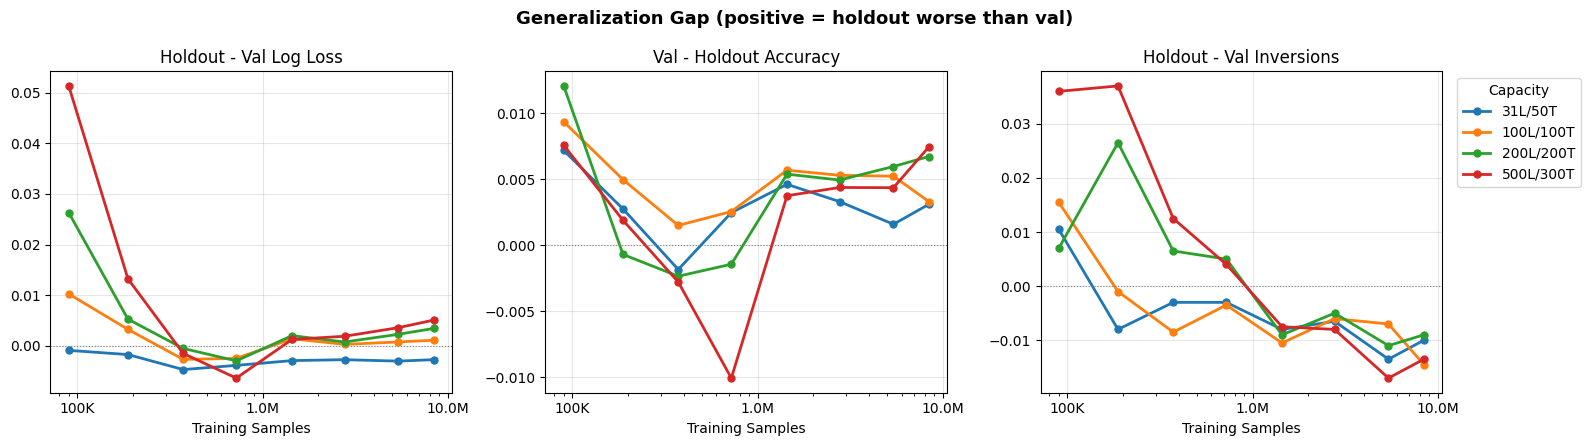

In [6]:
df['gap_log_loss'] = df['holdout_log_loss'] - df['val_log_loss']
df['gap_accuracy'] = df['val_accuracy'] - df['holdout_accuracy']  # val - holdout so positive = holdout worse
df['gap_inversions'] = df['holdout_inversions'] - df['val_inversions']

GAP_METRICS = [
    ('gap_log_loss', 'Holdout - Val Log Loss'),
    ('gap_accuracy', 'Val - Holdout Accuracy'),
    ('gap_inversions', 'Holdout - Val Inversions'),
]

fig, axes = plt.subplots(1, 3, figsize=(16, 4.5), sharex=True)

for col, (gap_col, label) in enumerate(GAP_METRICS):
    ax = axes[col]
    for cap in CAPACITIES:
        sub = df[df['capacity'] == cap].sort_values('num_train_samples')
        ax.plot(sub['num_train_samples'], sub[gap_col],
                marker='o', color=CAP_COLORS[cap], label=cap, linewidth=2, markersize=5)
    ax.axhline(0, color='gray', linewidth=0.8, linestyle=':')
    ax.set_xscale('log')
    ax.xaxis.set_major_formatter(mticker.FuncFormatter(fmt_samples))
    ax.set_title(label)
    ax.set_xlabel('Training Samples')
    ax.grid(True, alpha=0.3)

axes[2].legend(title='Capacity', bbox_to_anchor=(1.02, 1), loc='upper left')
fig.suptitle('Generalization Gap (positive = holdout worse than val)', fontsize=13, fontweight='bold')
fig.tight_layout()
plt.savefig('plot_gap_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

## 5. Summary

### Val vs Holdout — Key Differences

- **Validation** = partitions 905-924 (same distribution as training, just later in time)
- **Holdout** = late tournament games (different game context — high-stakes, selected players)

Patterns to look for:
- **Val tracks holdout closely for small models (31L/50T)** — low-capacity models can't overfit, so the domain gap is the main differentiator
- **Large models show bigger val-holdout gaps at small data sizes** — overfitting to training distribution makes the domain shift to tournament games more costly
- **Gaps shrink with more data** — at 100% data, even 500L/300T has a small gap, showing sufficient data regularizes
- **Holdout inversions can sometimes be *lower* than val** — tournament games may have more decisive outcomes that are easier to rank correctly

In [7]:
# Print the best configs
print('=== Best by Val Log Loss ===')
best_val = df.loc[df['val_log_loss'].idxmin()]
print(f"  {best_val['fraction']:.0%} data, {best_val['capacity']}: "
      f"val_loss={best_val['val_log_loss']:.4f}, holdout_loss={best_val['holdout_log_loss']:.4f}, "
      f"val_acc={best_val['val_accuracy']:.3%}, holdout_acc={best_val['holdout_accuracy']:.3%}")

print('\n=== Best by Holdout Log Loss ===')
best_ho = df.loc[df['holdout_log_loss'].idxmin()]
print(f"  {best_ho['fraction']:.0%} data, {best_ho['capacity']}: "
      f"val_loss={best_ho['val_log_loss']:.4f}, holdout_loss={best_ho['holdout_log_loss']:.4f}, "
      f"val_acc={best_ho['val_accuracy']:.3%}, holdout_acc={best_ho['holdout_accuracy']:.3%}")

print('\n=== Best by Val Accuracy ===')
best_va = df.loc[df['val_accuracy'].idxmax()]
print(f"  {best_va['fraction']:.0%} data, {best_va['capacity']}: "
      f"val_acc={best_va['val_accuracy']:.3%}, holdout_acc={best_va['holdout_accuracy']:.3%}")

=== Best by Val Log Loss ===
  100% data, 200L/200T: val_loss=0.5685, holdout_loss=0.5720, val_acc=69.226%, holdout_acc=68.553%

=== Best by Holdout Log Loss ===
  32% data, 100L/100T: val_loss=0.5698, holdout_loss=0.5701, val_acc=69.127%, holdout_acc=68.597%

=== Best by Val Accuracy ===
  64% data, 200L/200T: val_acc=69.262%, holdout_acc=68.665%
